# Arima Strategy

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
import scipy.stats as st
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv("A1_JPYUSD.csv", parse_dates = True, index_col = 0)
df

,Japan
1985-01-01,0.003927
1985-02-01,0.003854
1985-03-01,0.003960
1985-04-01,0.003964
1985-05-01,0.003971
...,...
2022-07-01,0.007519
2022-08-01,0.007214
2022-09-01,0.006909
2022-10-01,0.006746


<AxesSubplot:>

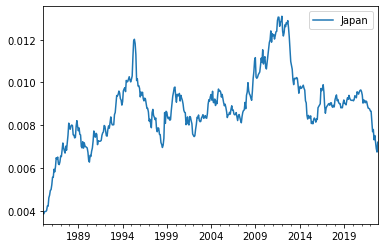

In [4]:
df.plot()

In [5]:
df.isna().sum()

Japan    0
dtype: int64

### Determine ARIMA hyperparameters

In [6]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['Japan'])

(-3.0474242986679476,
 0.030696697422626526,
 11,
 443,
 {'1%': -3.4451978474132234,
  '5%': -2.8680864144212057,
  '10%': -2.5702569996789792},
 -5950.11816566126)

The dataset is stationary.

In [7]:
cut = int((len(df) * .8) //1)
train_data = df[:cut]
test_data = df[cut:]

In [8]:
adfuller(train_data['Japan'])

(-2.7960258068289927,
 0.058843699553557914,
 11,
 352,
 {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306},
 -4690.279002073191)

In [9]:
adfuller(test_data['Japan'])

(-0.694410394255295,
 0.848192063992566,
 0,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 -1096.9999186987409)

<AxesSubplot:>

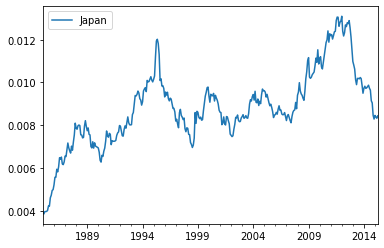

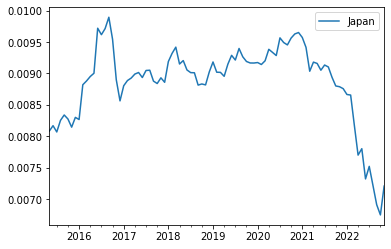

In [10]:
train_data.plot()
test_data.plot()

The both train and test data are not stationary.

In [11]:
import pmdarima as pm
model = pm.auto_arima(train_data, start_p = 0, start_q = 0, test='adf', 
                      suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2462.691
Date:                Sat, 28 Jan 2023   AIC                          -4919.383
Time:                        06:15:09   BIC                          -4907.700
Sample:                    01-01-1985   HQIC                         -4914.739
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0900      0.045      2.018      0.044       0.003       0.177
ar.L2          0.0947      0.050      1.898      0.058      -0.003       0.192
sigma2      7.494e-08   4.22e-09     17.775      0.000    6.67e-08    8.32e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model.order

(2, 1, 0)

### Forecasting

In [13]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    upper = list()
    lower = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        forecasts = model_fit.get_forecast()
        yhat_conf_int = forecasts.conf_int(alpha=0.1)
        yhat = forecasts.predicted_mean
        predictions.append(yhat[0])
        lower.append(yhat_conf_int[0][0])
        upper.append(yhat_conf_int[0][1])
        history.append(test[t])
    
    test = pd.DataFrame(test)
    test["lower"] = lower
    test["prediction"] = predictions
    test["upper"] = upper
    return test

In [14]:
y = evaluate_arima_model(df['Japan'], (2,1,0))

In [15]:
y 

,Japan,lower,prediction,upper
2015-05-01,0.008081,0.007992,0.008443,0.008893
2015-06-01,0.008167,0.007609,0.008060,0.008510
2015-07-01,0.008066,0.007690,0.008140,0.008590
2015-08-01,0.008251,0.007616,0.008066,0.008516
2015-09-01,0.008337,0.007808,0.008257,0.008706
...,...,...,...,...
2022-07-01,0.007519,0.006856,0.007285,0.007715
2022-08-01,0.007214,0.007062,0.007491,0.007921
2022-09-01,0.006909,0.006779,0.007208,0.007638
2022-10-01,0.006746,0.006424,0.006853,0.007283


### Backtest

In [16]:
y["Signals"] = np.where(y["prediction"]>y['Japan'].shift(), 1,-1)
y["returns"] = np.log(y["Japan"]/y["Japan"].shift())
y["strategy returns"] = y["Signals"]*y["returns"]
y["Cumulative Returns"] = (np.exp(y["strategy returns"].cumsum())-1)*100
y["Cumulative Returns"]

2015-05-01          NaN
2015-06-01    -1.050505
2015-07-01     0.177778
2015-08-01    -2.060606
2015-09-01    -1.039979
                ...    
2022-07-01    34.116372
2022-08-01    39.773461
2022-09-01    45.954915
2022-10-01    49.484293
2022-11-01    39.965056
Name: Cumulative Returns, Length: 91, dtype: float64

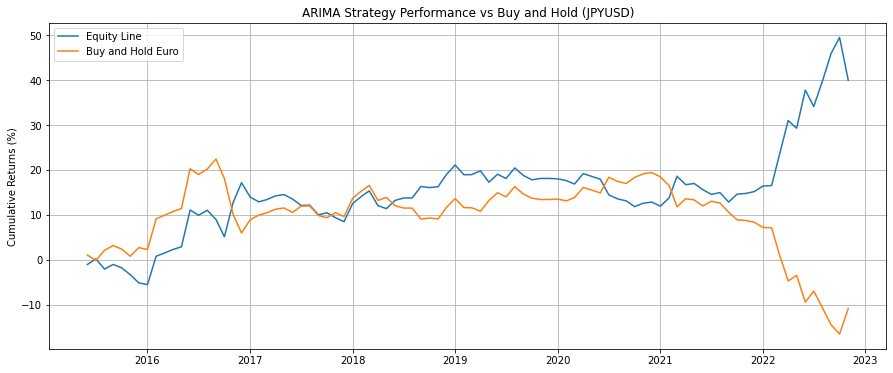

In [17]:
plt.figure(figsize = (15, 6))
plt.plot(y["Cumulative Returns"])
plt.plot((np.exp(y["returns"].cumsum())-1)*100)
plt.ylabel("Cumulative Returns (%)")
plt.title("ARIMA Strategy Performance vs Buy and Hold (JPYUSD)")
plt.legend(["Equity Line", "Buy and Hold Euro"])
plt.grid()

### CCROR

In [18]:
P = 1000000
A = (((y["Cumulative Returns"]/100)+1)*P)[-1]
t = (len(y)/12)
CCROR = np.log(A/P)/t
print(CCROR*100)

4.433704663592737


In [19]:
((A/P)**(1/t)-1)*100

4.533462203765626

### DMW

In [20]:
y['change'] = y.Japan - y.Japan.shift()
y['error'] = y['change'] - (y.prediction - y.Japan.shift())
y['change_fit'] = y.prediction - y.Japan.shift()

In [21]:
y

,Japan,lower,prediction,upper,Signals,returns,strategy returns,Cumulative Returns,change,error,change_fit
2015-05-01,0.008081,0.007992,0.008443,0.008893,-1,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-01,0.008167,0.007609,0.008060,0.008510,-1,0.010561,-0.010561,-1.050505,0.000086,0.000107,-2.085781e-05
2015-07-01,0.008066,0.007690,0.008140,0.008590,-1,-0.012337,0.012337,0.177778,-0.000100,-0.000073,-2.690069e-05
2015-08-01,0.008251,0.007616,0.008066,0.008516,-1,0.022598,-0.022598,-2.060606,0.000184,0.000185,-3.476334e-07
2015-09-01,0.008337,0.007808,0.008257,0.008706,1,0.010367,0.010367,-1.039979,0.000086,0.000080,6.060443e-06
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.007519,0.006856,0.007285,0.007715,-1,0.026927,-0.026927,34.116372,0.000200,0.000234,-3.383881e-05
2022-08-01,0.007214,0.007062,0.007491,0.007921,-1,-0.041315,0.041315,39.773461,-0.000304,-0.000277,-2.756801e-05
2022-09-01,0.006909,0.006779,0.007208,0.007638,-1,-0.043275,0.043275,45.954915,-0.000306,-0.000299,-6.056780e-06
2022-10-01,0.006746,0.006424,0.006853,0.007283,-1,-0.023894,0.023894,49.484293,-0.000163,-0.000108,-5.557997e-05


In [22]:
# Taylor Rule Model
P = len(y['error'])
MSE_T = np.sum(np.square(y['error']))/P
MSE_T

4.215419734415691e-08

In [23]:
# Random Walk
MSE_R = np.sum(np.square(y['change']))/P
MSE_R

4.2298705334510525e-08

In [24]:
error_R = y['change'].reset_index(drop=True)
error_T = y['error'].reset_index(drop=True)
tmp = np.square(error_R) - np.square(error_T) - (MSE_R - MSE_T)
V_hat = np.sum(np.square(tmp))/P

In [25]:
## DMW Statistic
DMW = (MSE_R - MSE_T)/np.sqrt(V_hat/P)

print('Since the DMW statitsic is equal to ' + str(DMW) + ',' + ' which is less than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the MP model does not outperform the random walk model.')

Since the DMW statitsic is equal to 0.11174596641004998, which is less than the critical value (1.64),
we fail to reject the null hypothesis that the MP model does not outperform the random walk model.


In [26]:
### CW statistic
tmp2 = np.sum(np.square(y['change_fit']))/P
CW = (MSE_R - MSE_T + tmp2)/np.sqrt(V_hat/P)

print('Since the CW statitsic is equal to ' + str(CW) + ',' + ' which is less than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the MP model does not outperform the random walk model.')

Since the CW statitsic is equal to 0.6907368245783108, which is less than the critical value (1.64),
we fail to reject the null hypothesis that the MP model does not outperform the random walk model.


### Sharpe ratio

In [35]:
rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
rf_rate.head()

,value
date,
1962-01-02,3.22
1962-01-03,3.24
1962-01-04,3.24
1962-01-05,3.26
1962-01-08,3.31


In [36]:
yrf = y[['Japan', 'prediction', 'returns']]

In [64]:
drange = pd.date_range(start = "2015/04/01", periods = 91, freq = "M")
yrf.index = drange
yrf["rf"] = rf_rate

In [65]:
yrf

,Japan,prediction,returns,rf
2015-04-30,0.008081,0.008443,NaN,0.24
2015-05-31,0.008167,0.008060,0.010561,NaN
2015-06-30,0.008066,0.008140,-0.012337,0.28
2015-07-31,0.008251,0.008066,0.022598,0.33
2015-08-31,0.008337,0.008257,0.010367,0.39
...,...,...,...,...
2022-06-30,0.007519,0.007285,0.026927,2.80
2022-07-31,0.007214,0.007491,-0.041315,NaN
2022-08-31,0.006909,0.007208,-0.043275,3.50
2022-09-30,0.006746,0.006853,-0.023894,4.05


In [66]:
rfs = yrf["rf"].resample("Y").first()[1:-1]

In [67]:
t = len(rfs)
rfp = ((((rfs/100)+1).cumprod()[-1])**(1/t)-1)
rfp

0.012214472324448389

In [68]:
yrf["rf"] = rf_rate
yrf["rf"] = yrf["rf"].ffill()

In [69]:
return_frame = yrf[["returns"]].copy().dropna()
return_frame["rf"] = (yrf[["rf"]].dropna()/100+1)**(1/12)-1
excess_return = return_frame["returns"]- return_frame["rf"]

In [70]:
anualized_excess = ((excess_return+1).prod()**(12/len(yrf))-1)*100
anualized_excess

-3.000696437314021

In [71]:
excess_ann_std = excess_return.std()*np.sqrt(12)*100
print((anualized_excess)/excess_ann_std)

-0.3557389203836914


In [72]:
n = len(excess_return)
mean = excess_return.mean()
std = np.sqrt(np.sum(np.square(excess_return))/(n-1))
mean/std*np.sqrt(12)

-0.3214385221869183